In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import ipdb


print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
class KITTIDataset(Dataset):
    def __init__(self, pointcloud_dir, labels_dir):
        """
        Args:
            root_dir (string): Directory with all the point clouds.
        """
        self.pointcloud_dir = pointcloud_dir
        self.pointcloud_files = [f for f in os.listdir(self.pointcloud_dir) if
                                  os.path.isfile(os.path.join(self.pointcloud_dir, f))]
        self.labels_dir = labels_dir
        self.labels_files = [f for f in os.listdir(self.labels_dir) if 
                             os.path.isfile(os.path.join(self.labels_dir, f))]
        

    def __len__(self):
        return len(self.self.pointcloud_files)
    

    def __getitem__(self, idx):
        # Retrieve pointcloud:
        point_cloud_path = os.path.join(self.pointcloud_dir, self.pointcloud_files[idx])
        point_cloud = self.load_point_cloud_from_bin(point_cloud_path)

        # Retrieve label:
        label_file = self.pointcloud_files[idx]
        label_file = label_file[:-3] + 'txt'
        label_path = os.path.join(self.labels_dir, label_file)
        labels = self.parse_kitti_label_file(label_path)
        return point_cloud, labels
    
    
    def load_point_cloud_from_bin(self, bin_path):
        print(f'File loaded: {bin_path}')
        with open(bin_path, 'rb') as f:
            content = f.read()
            point_cloud = np.frombuffer(content, dtype=np.float32)
            point_cloud = point_cloud.reshape(-1, 4)  # KITTI point clouds are (x, y, z, intensity)
        return torch.from_numpy(point_cloud)
    
    
    def parse_kitti_label_file(self, label_path):

        labels = {'Car': []}  # Initialize a dictionary for 'Car' and more classes that would like to be added
        classes_list = list(labels.keys()) # Get dictionary keys as list

        with open(label_path, 'r') as file:
            for line in file:
                parts = line.split()
                label_type = parts[0]
                if label_type in classes_list:  # Here more classes can be added
                    truncated = float(parts[1])
                    occluded = int(parts[2])
                    alpha = float(parts[3])
                    bbox = [float(x) for x in parts[4:8]]
                    dimensions = [float(x) for x in parts[8:11]]
                    location = [float(x) for x in parts[11:14]]
                    rotation_y = float(parts[14])
                    # Optionally handle the score if it exists.
                    score = float(parts[15]) if len(parts) > 15 else None
                        

                    annotation = {
                        'truncated': truncated,
                        'occluded': occluded,
                        'alpha': alpha,
                        'bbox': bbox,
                        'dimensions': dimensions,
                        'location': location,
                        'rotation_y': rotation_y,
                        'score': score
                    }

                    
                    labels[label_type].append(annotation)       

                else:
                    continue
             


        return labels

      

train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
#train_full_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne' # FIXME: Comment
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'


test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# TODO: Add Loader for test set (No labels)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin


/tmp/ipykernel_437343/2310630797.py:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


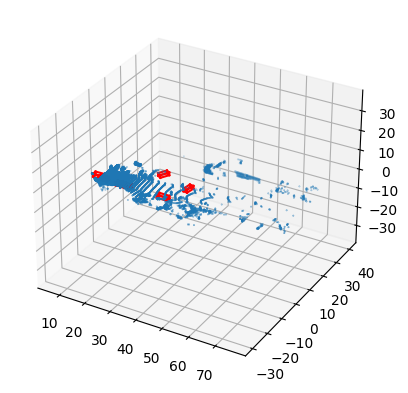

In [3]:
# Visualize some point clouds with its bounding boxes:
# Note: This is just for visualization purposes


def draw_box(ax, vertices, color='r'):
    # Define the order of the vertices for the lines to draw the edges of the 3D bounding box
    lines = [
        [vertices[i], vertices[j]] for i, j in [
            (0, 1), (1, 2), (2, 3), (3, 0),  # lower edges
            (4, 5), (5, 6), (6, 7), (7, 4),  # upper edges
            (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
        ]
    ]
    # Plot the lines
    for line in lines:
        ax.plot3D(*zip(*line), color=color)


def plot_point_cloud_with_bboxes(point_cloud, annotations):
    # Assuming 'point_cloud' is a NumPy array of shape (-1, 4)
    # 'annotations' is a list of dictionaries with 'bbox', 'dimensions', 'location', 'rotation_y'

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the point cloud
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.1)

    # For each car annotation, draw the bounding box
    for annotation in annotations.get('Car', []):
        h, w, l = annotation['dimensions']
        y, z, x = annotation['location'] # TODO: Verify if it is x, y, z or order is wrong
        ry = annotation['rotation_y']


        # Create a bounding box in the vehicle's reference frame
        corners = np.array([
            [l / 2, w / 2, 0],
            [-l / 2, w / 2, 0],
            [-l / 2, -w / 2, 0],
            [l / 2, -w / 2, 0],
            [l / 2, w / 2, h],
            [-l / 2, w / 2, h],
            [-l / 2, -w / 2, h],
            [l / 2, -w / 2, h],
        ])

        # Rotate the bounding box
        rotation_matrix = np.array([
            [np.cos(ry), -np.sin(ry), 0],
            [np.sin(ry), np.cos(ry), 0],
            [0, 0, 1]
        ])
        corners_rotated = np.dot(corners, rotation_matrix.T)

        # Translate the bounding box
        corners_rotated += np.array([x, y, z])

        # Draw the bounding box
        draw_box(ax=ax, vertices=corners_rotated)

    # Set axes limits
    max_range = np.array([point_cloud[:, 0].max() - point_cloud[:, 0].min(),
                          point_cloud[:, 1].max() - point_cloud[:, 1].min(),
                          point_cloud[:, 2].max() - point_cloud[:, 2].min()]).max() / 2.0

    mid_x = (point_cloud[:, 0].max() + point_cloud[:, 0].min()) * 0.5
    mid_y = (point_cloud[:, 1].max() + point_cloud[:, 1].min()) * 0.5
    mid_z = (point_cloud[:, 2].max() + point_cloud[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

# Example usage:
point_cloud, labels = train_set[0]  # Replace 0 with the index of the point cloud you want to visualize
plot_point_cloud_with_bboxes(point_cloud.numpy(), labels)



How are we getting labels?

In [4]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

class PillarFeatureNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PillarFeatureNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        
        self.to(device)

    
    def forward(self, x):
        # Input x is of shape (D, P, N)
        # Convert it to (P, D, N) for 1x1 convolution      
        x = x.to(device)
        x = x.permute(1, 0, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Max pooling operation over the points' dimension
        x, _ = torch.max(x, dim=2)  # Output shape: (P, C)
        return x.T  # Output shape: (C, P)




class Pillarization:
    def __init__(self, x_min, x_max, y_min, y_max, z_min, z_max, pillar_size,
                max_points_per_pillar, aug_dim, max_pillars):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.z_min = z_min
        self.z_max = z_max
        self.pillar_size = pillar_size
        self.max_points_per_pillar = max_points_per_pillar
        self.aug_dim = aug_dim
        self.num_x_pillars = int((self.x_max - self.x_min) / self.pillar_size[0])
        self.num_y_pillars = int((self.y_max - self.y_min) / self.pillar_size[1])
        self.max_pillars = max_pillars
        

    def make_pillars(self, points):
        """
        Convert point cloud (x, y, z) into pillars.
        """
        # Mask points outside of our defined boundaries
        
        mask = (
            (points[:, 0] >= self.x_min) & (points[:, 0] <= self.x_max) &
            (points[:, 1] >= self.y_min) & (points[:, 1] <= self.y_max) &
            (points[:, 2] >= self.z_min) & (points[:, 2] <= self.z_max)
        )
        points = points[mask]
        

        pillars = torch.zeros((self.num_x_pillars, self.num_y_pillars, self.max_points_per_pillar, 
            self.aug_dim)) # Size 
        
        # Count how many points are in each pillar to ensure we don't exceed `max_points_per_pillar`
        count = torch.zeros((self.num_x_pillars, self.num_y_pillars), dtype=torch.long)

        
        if (device != torch.device('cpu')): # To CUDA if available (GPU?)
            self.x_indices.to(device)
            self.y_indices.to(device)
            points = points.to(device)
            pillars = pillars.to(device)
            count = count.to(device)
        
        # Calculate x,y indices for each point:
        self.x_indices = points[:,0] - self.x_min / self.pillar_size[0]
        self.y_indices = points[:,1] - self.y_min / self.pillar_size[1] 

        self.x_indices = self.x_indices.int()
        self.y_indices = self.y_indices.int()

   
        # TODO: Store points in the pillars in a vectorized way filling the pillars tensor:        
        for i in range(points.shape[0]):
            x_ind = self.x_indices[i]
            y_ind = self.y_indices[i]
            
            if count[x_ind, y_ind] < self.max_points_per_pillar:
                # Compute x_c, y_c and z_c
                x_c = (x_ind * self.pillar_size[0] + self.pillar_size[0] / 2.0) - points[i, 0]
                y_c = (y_ind * self.pillar_size[1] + self.pillar_size[1] / 2.0) - points[i, 1]
                z_c = (self.z_min + self.z_max) / 2 - points[i, 2] # assuming the z-center is the midpoint
                
                # Calculate pillar center
                x_pillar_center = (x_ind * self.pillar_size[0] + self.pillar_size[0] / 2.0)
                y_pillar_center = (y_ind * self.pillar_size[1] + self.pillar_size[1] / 2.0)
                
                # Add original x, y, and z coordinates, then x_c, y_c, z_c
                pillars[x_ind, y_ind, count[x_ind, y_ind], :3] = points[i, :3]
                
                if (device != torch.device('cpu')): 
                    pillars[x_ind, y_ind, count[x_ind, y_ind], 3:6] = torch.tensor([x_c, y_c, z_c]).to(device)
                else: 
                    pillars[x_ind, y_ind, count[x_ind, y_ind], 3:6] = torch.tensor([x_c, y_c, z_c])
                    
                pillars[x_ind, y_ind, count[x_ind, y_ind], 6] = x_pillar_center - pillars[x_ind, y_ind, count[x_ind, y_ind], 0]
                pillars[x_ind, y_ind, count[x_ind, y_ind], 7] = y_pillar_center - pillars[x_ind, y_ind, count[x_ind, y_ind], 1]
                
                count[x_ind, y_ind] += 1
                
        
        # Limit the number of pillars:

        # Flatten the count tensor and get the indices of the top P pillars
        flat_count = count.view(-1)  # Flatten the count tensor to 1D
        _, top_pillar_flat_indices = flat_count.topk(self.max_pillars, largest=True)  # Get the indices of the top pillars
        
        # Convert the flat indices back to 2D indices
        top_pillar_x_indices = (top_pillar_flat_indices // self.num_y_pillars)
        top_pillar_y_indices = (top_pillar_flat_indices % self.num_y_pillars)
        
        # Create a new tensor to hold the top pillars
        top_pillars = torch.zeros((self.max_pillars, self.max_points_per_pillar, self.aug_dim)) # Size (P, N, D)
        
        # Fill in the top pillars
        for i, (x_ind, y_ind) in enumerate(zip(top_pillar_x_indices, top_pillar_y_indices)):
            current_pillar_points = count[x_ind, y_ind]
    
            # Zero-padding if too few point, random sampling if too many points:
            if current_pillar_points > self.max_points_per_pillar:
                # If there are more points than the max, randomly select max_points_per_pillar
                perm = torch.randperm(current_pillar_points)[:self.max_points_per_pillar]
                top_pillars[i] = pillars[x_ind, y_ind][perm]
            elif current_pillar_points < self.max_points_per_pillar:
                # If there are fewer, zero-pad the pillar
                top_pillars[i, :current_pillar_points] = pillars[x_ind, y_ind][:current_pillar_points]
                # Remaining positions are already zero because of the zero initialization of top_pillars                

        # Reshape pillars to size (D,P,N) from (P,N,D):
        top_pillars = top_pillars.permute(2, 0, 1) 

        return top_pillars, top_pillar_x_indices, top_pillar_y_indices



    
# Test Pillarization:
'''pillarizer = Pillarization(aug_dim=9, x_min=0.0, x_max=70.4, y_min=-40.0, y_max=40.0, 
                                        z_min=-3, z_max=1, pillar_size=(0.16, 0.16), 
                                        max_points_per_pillar=100, max_pillars=12000)

pillars = pillarizer.make_pillars(train_set[0][0])'''



'pillarizer = Pillarization(aug_dim=9, x_min=0.0, x_max=70.4, y_min=-40.0, y_max=40.0, \n                                        z_min=-3, z_max=1, pillar_size=(0.16, 0.16), \n                                        max_points_per_pillar=100, max_pillars=12000)\n\npillars = pillarizer.make_pillars(train_set[0][0])'

In [5]:
class PseudoImageDataset(Dataset):
    def __init__(self, pointcloud_dir, D, N, transform=None):
        self.pointcloud_dir = pointcloud_dir
        self.filenames = [f for f in os.listdir(self.pointcloud_dir) if os.path.isfile(os.path.join(self.pointcloud_dir, f))]
        self.transform = transform
        
        self.pillarizer = Pillarization(aug_dim=D, x_min=0.0, x_max=70.4, y_min=-40.0, y_max=40.0, 
                                        z_min=-3, z_max=1, pillar_size=(0.16, 0.16), max_points_per_pillar=N, max_pillars=12000)
        
        
        
        self.feature_extractor = PillarFeatureNet(D, 64) # Size (C,P) 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        point_cloud, label = train_set[idx] #.load_point_cloud_from_bin(os.path.join(self.pointcloud_dir, self.filenames[idx]))
        pillars, x_orig_indices, y_orig_indices = self.pillarizer.make_pillars(point_cloud)
        
        # Apply linear activation, batchnorm, and ReLU for feature extraction from pillars tensor
        features = self.feature_extractor(pillars) # Output of size (C,P)
        
        # Generate pseudo-image:
        pseudo_image = torch.zeros(features.shape[0], self.pillarizer.num_y_pillars, self.pillarizer.num_x_pillars).to(device)
        
        # Scatter the features back to their original pillar locations

        print(f'Loading point cloud number {idx}')

        # Fill pseudo_image with features:
        for c in range(features.shape[0]):
            pseudo_image[c, y_orig_indices, x_orig_indices] = features[c]

        '''for i in range(features.shape[1]):
            x_ind = self.pillarizer.x_indices[i].long() # SUS: Is the indexing here correct?
            y_ind = self.pillarizer.y_indices[i].long()
            pseudo_image[:, y_ind, x_ind] = features[:, i] # (C, H, W)'''

        
        if self.transform:
            pseudo_image = self.transform(pseudo_image)
            
        return pseudo_image, label


# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    
    # Convert lists of point clouds and annotations into tensors
    point_clouds = torch.stack(point_clouds, dim=0)
    
    # Padding for variable-sized labels:
    max_annotations = max(len(a['Car']) for a in annotations)
    padded_annotations = []
    for a in annotations:
        # Pad each annotation to have max_annotations entries
        car_annotations = a['Car'] + [{}] * (max_annotations - len(a['Car']))
        padded_annotations.append({'Car': car_annotations})
    
    return point_clouds, padded_annotations

        
# Create the dataset and DataLoader
D = 9
N = 100
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir , D=D, N=N)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)


# Iterate through batches:  
for batch_idx, (pseudo_image, label) in enumerate(train_loader):
    break # TODO: Erase this and load the entire dataset

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/000425.bin
Loading point cloud number 202
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/000719.bin
Loading point cloud number 7388
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/001520.bin
Loading point cloud number 3174
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006043.bin
Loading point cloud number 3886


In [36]:
pseudo_image.size()

torch.Size([4, 64, 500, 440])

Now, get batches of data:

In [7]:
pseudo_image.size()


torch.Size([4, 64, 500, 440])

In [8]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

In [9]:

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, L, stride):
        super(Block, self).__init__()
        layers = []
        # First layer with the specified stride
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        layers.append(nn.BatchNorm2d(out_channels)) # TODO -> Uncomment and batch
        layers.append(nn.ReLU(inplace=True))
        
        # Subsequent layers with stride 1
        for _ in range(1, L):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, stride, output_padding):
        super(UpSample, self).__init__()
        # Assuming stride_out is always half of stride_in based on the diagram
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm2d(out_channels), # TODO> Uncomment and batch
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.up(x)

class BackBone(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BackBone, self).__init__()
        self.to(device)
        # Define blocks with arbitrary L for now (can be tuned based on requirements)
        self.block1 = Block(in_channels, out_channels*2, L=3, stride=1)
        self.block2 = Block(out_channels*2, out_channels*2, L=3, stride=2)
        self.block3 = Block(out_channels*2, out_channels*2, L=3, stride=2)
        

        # Define upsampling layers        
        self.up1 = UpSample(out_channels*2, out_channels*2, stride=1, output_padding=0)
        self.up2 = UpSample(out_channels*2, out_channels*2, stride=2, output_padding=1)
        self.up3 = UpSample(out_channels*2, out_channels*2, stride=4, output_padding=3)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x2.size()
        # Upsample and concatenate
        up_x1 = self.up1(x1)   
        up_x2 = self.up2(x2)
        up_x3 = self.up3(x3)     
        concat_features = torch.cat([up_x1, up_x2, up_x3], dim=1)
        
        return concat_features


backbone = BackBone(in_channels=64, out_channels=64).to(device)
backbone_features = backbone(pseudo_image.to(device))

In [10]:
backbone_features.size()




torch.Size([4, 384, 500, 440])

Now, implement the Detection Head:

In [11]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, grid_size_x, grid_size_y, num_anchors, num_classes):
        super(DetectionHead, self).__init__()
        self.grid_size_x = grid_size_x
        self.grid_size_y = grid_size_y
        self.num_anchors = num_anchors
        self.num_classes = num_classes

        # Assuming 4 anchor boxes per cell
        self.loc_layer = nn.Conv2d(in_channels, num_anchors * 3, 1)
        self.size_layer = nn.Conv2d(in_channels, num_anchors * 3, 1)
        self.clf_layer = nn.Conv2d(in_channels, num_anchors * (num_classes + 1), 1) # +1 for confidence score
        self.occupancy_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)
        self.angle_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)
        self.heading_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)

    def forward(self, x):
        loc = self.loc_layer(x).view(x.size(0), self.num_anchors, 3, self.grid_size_x, self.grid_size_y)
        size = self.size_layer(x).view(x.size(0), self.num_anchors, 3, self.grid_size_x, self.grid_size_y)
        clf = self.clf_layer(x).view(x.size(0), self.num_anchors, self.num_classes + 1, self.grid_size_x, self.grid_size_y)
        occupancy = self.occupancy_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)
        angle = self.angle_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)
        heading = self.heading_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)

        return loc, size, clf, occupancy, angle, heading


#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(backbone_features.size()[1], backbone_features.size()[2], 
                        backbone_features.size()[3], num_anchors=4, num_classes=2).to(device) # Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [12]:
size.size()

torch.Size([4, 4, 3, 500, 440])

Create anchors for Single-Shot Detector:

/home/adlink/anaconda3/envs/test/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


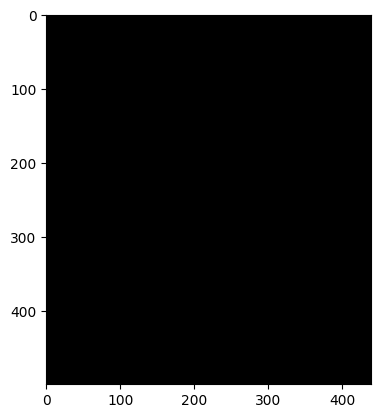

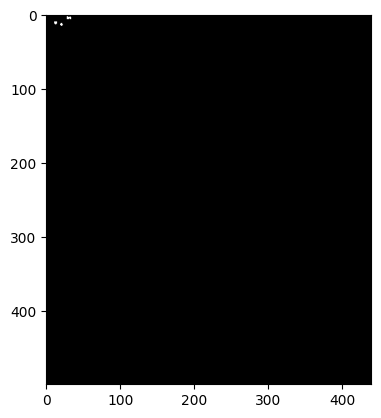

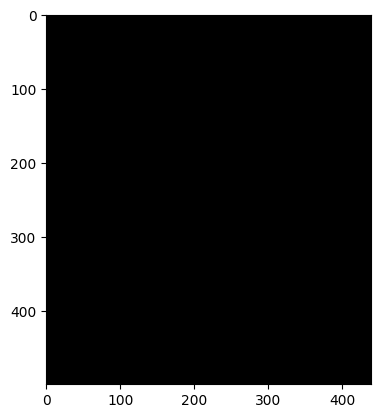

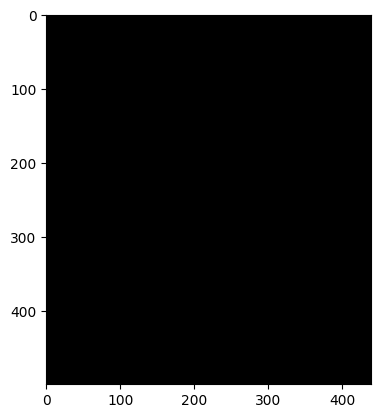

In [37]:
# Anchors as tensor: (length, width, height, z_center, orientation)
anchor_dims = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # TODO: Declare at the top
                       [3.9, 1.6, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.8, 0.6, 1.73, -0.6, 1.5708]]
                       )


# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for gt_label in label:
    if gt_label['Car'] == [{}, {}, {}, {}, {}, {}, {}]:
        continue

    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)

    # Empty canvas for visualization if needed:
    canvas = torch.zeros(loc.size()[-2], loc.size()[-1])

    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}: # If true, done with target generation
            break
        x_center = gt_label['Car'][i]['location'][2]
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        # TODO: Transform targets to pseudo_image_frame:
        

        target_radius = max(height, width)
        target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius])

        # TODO: Mask canvas to display circles if visualization is needed:
        y, x = torch.meshgrid(torch.arange(canvas.size(0)), torch.arange(canvas.size(1)))
        mask = (x - x_center) ** 2 + (y - y_center) ** 2 <= target_radius ** 2
        canvas[mask] = 1  # Set the masked locations to 1

    canvas_numpy = canvas.numpy()
    plt.imshow(canvas_numpy, cmap='gray')
    plt.show()


        # TODO: Apply each anchor and get the anchor with the highest IoU:

        

    

In [35]:
loc.size()[-1]

440

In [26]:
anchor_dims

tensor([[ 3.9000,  1.6000,  1.5600, -1.0000,  0.0000],
        [ 3.9000,  1.6000,  1.5600, -1.0000,  1.5708],
        [ 0.8000,  0.6000,  1.7300, -0.6000,  0.0000],
        [ 0.8000,  0.6000,  1.7300, -0.6000,  1.5708]])

In [27]:



# TODO: createPillarsTarget function: This function is tasked with generating regression targets, which are 
# essential for subsequent loss value calculations. It follows these steps:


# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for gt_label in label:
    if gt_label['Car'] == [{}, {}, {}, {}, {}, {}, {}]:
        continue

    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)

    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}:
            n_objects = i
            break

        #target_radii.append(TargetRadius(x_center=gt_label['Car'][i]['location'][2], 
        #                        y_center=gt_label['Car'][i]['location'][0], radius=6.0))
        x_center = gt_label['Car'][i]['location'][2]
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        target_radius = max(height, width)
        target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius])


RuntimeError: The expanded size of the tensor (2) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [2].  Tensor sizes: [3]

In [23]:
label

[{'Car': [{}, {}, {}, {}, {}, {}, {}]},
 {'Car': [{'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.57,
    'bbox': [571.3, 178.99, 603.66, 208.48],
    'dimensions': [1.6, 1.76, 3.84],
    'location': [-1.18, 1.26, 41.34],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.93,
    'occluded': 0,
    'alpha': -0.81,
    'bbox': [0.0, 209.69, 212.48, 375.0],
    'dimensions': [1.38, 1.71, 4.49],
    'location': [-4.78, 1.64, 4.77],
    'rotation_y': -1.56,
    'score': None},
   {'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.09,
    'bbox': [85.19, 186.17, 282.49, 280.48],
    'dimensions': [1.54, 1.65, 3.82],
    'location': [-8.03, 1.58, 14.0],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha': -1.18,
    'bbox': [246.43, 185.37, 368.07, 246.86],
    'dimensions': [1.49, 1.67, 4.05],
    'location': [-8.22, 1.52, 19.98],
    'rotation_y': -1.57,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha

Now, create the loss function:

In [17]:

class PointPillarLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(PointPillarLoss, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Unpack predictions and targets
        pred_boxes, pred_scores = predictions
        gt_boxes, gt_scores = targets
        
        # Calculate the residuals for the boxes
        da = torch.sqrt((pred_boxes[:, 3] - pred_boxes[:, 0])**2 + (pred_boxes[:, 4] - pred_boxes[:, 1])**2)
        dx = (gt_boxes[:, 0] - pred_boxes[:, 0]) / da
        dy = (gt_boxes[:, 1] - pred_boxes[:, 1]) / da
        dz = (gt_boxes[:, 2] - pred_boxes[:, 2]) / pred_boxes[:, 5]
        dw = torch.log(gt_boxes[:, 3] / pred_boxes[:, 3])
        dl = torch.log(gt_boxes[:, 4] / pred_boxes[:, 4])
        dh = torch.log(gt_boxes[:, 5] / pred_boxes[:, 5])
        dtheta = torch.sin(gt_boxes[:, 6] - pred_boxes[:, 6])
        
        # Stack the residuals
        residuals = torch.stack((dx, dy, dz, dw, dl, dh, dtheta), dim=1)
        
        # Calculate the SmoothL1 loss for localization
        loc_loss = self.smooth_l1_loss(pred_boxes, residuals)
        
        # Calculate the Focal loss for classification
        p = torch.sigmoid(pred_scores)
        pt = p * gt_scores + (1 - p) * (1 - gt_scores)  # p_t
        alpha_t = self.alpha * gt_scores + (1 - self.alpha) * (1 - gt_scores)
        cls_loss = -alpha_t * (1 - pt) ** self.gamma * (gt_scores * torch.log(p) + (1 - gt_scores) * torch.log(1 - p))
        
        # Sum up the localization and classification losses
        total_loss = loc_loss + cls_loss.sum()
        
        return total_loss

# Example usage:
model = ...  # Your model here
criterion = PointPillarLoss()

# Predictions from the model
pred_boxes = ...  # Your predicted boxes here (Nx7)
pred_scores = ...  # Your predicted scores here (Nx1)

# Targets
gt_boxes = ...  # Your ground truth boxes here (Nx7)
gt_scores = ...  # Your ground truth scores here (Nx1)

# Compute the loss
loss = criterion((pred_boxes, pred_scores), (gt_boxes, gt_scores))



[{'Car': [{}, {}, {}, {}, {}, {}, {}]},
 {'Car': [{'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.57,
    'bbox': [571.3, 178.99, 603.66, 208.48],
    'dimensions': [1.6, 1.76, 3.84],
    'location': [-1.18, 1.26, 41.34],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.93,
    'occluded': 0,
    'alpha': -0.81,
    'bbox': [0.0, 209.69, 212.48, 375.0],
    'dimensions': [1.38, 1.71, 4.49],
    'location': [-4.78, 1.64, 4.77],
    'rotation_y': -1.56,
    'score': None},
   {'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.09,
    'bbox': [85.19, 186.17, 282.49, 280.48],
    'dimensions': [1.54, 1.65, 3.82],
    'location': [-8.03, 1.58, 14.0],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha': -1.18,
    'bbox': [246.43, 185.37, 368.07, 246.86],
    'dimensions': [1.49, 1.67, 4.05],
    'location': [-8.22, 1.52, 19.98],
    'rotation_y': -1.57,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha